---
title: Linear Ensemble
date: 2017-08-17 10:00:00
tags: [regressão, modelos-compostos]
author: Jader Martins
---

# Linear Ensemble of Regressors for Price Estimates

Pricing certain items before they enter the market is essential for good acceptance and consumption. Making a product available at the market below the market price does not give you good returns, but also a very high value does not appeal to buyers, regressive models in this case are of great help in making the decision about the pricing of an input. The predictive performance of composite models compared to simple models has been remarkable in many areas [^1], simple models are those that use [pure machine learning algorithms](https://en.wikipedia.org/wiki/Machine_learning#Models), whereas composite models combine the predictions of two or more algorithms in an attempt to improve the prediction. In this post I will try to present efficient ways to combine models to minimize the error of Boston's square-meter property price predictions.

### Preparing the Data
Here I will use a famous house price dataset, but the technique discussed here can be extended to pricing almost anything. First I will import and load my dataset into the “boston” variable using Pandas, the Python module famous for its data analysis focused on finance. The dataset comes from the Scikit-Learn module that we will use throughout this post to work with AM, it provides tools from data handling to a machine learning _pipeline_. We will also use the Numpy module.

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

boston = load_boston()

df = pd.DataFrame(
    np.column_stack([boston.data, boston.target]), 
    columns=np.r_[boston.feature_names, ['MEDV']])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Here I load my data into the *df* variable and show the first 5 lines with the head command.

We have information like crime of the region, average age of the population, etc ..
Although it is not the focus of this post, the distribution of our data may cause our regressor to make it very difficult, so I will apply a simple feature engineering to make our distribution more normal, in future posts will be explained in detail what is feature engineering and how to use it to improve your predictions. First let's see how the distribution we want to predict next to the "normalized" distribution by $log (x + 1)$, (adding one to the value avoids us having problems with zeros).

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", palette="coolwarm")

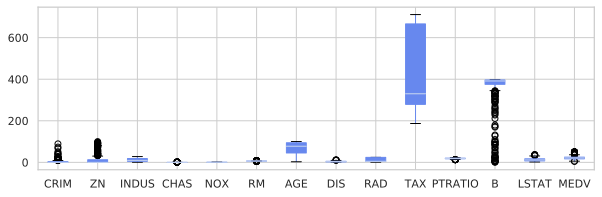

In [3]:
df.plot.box(figsize=(10,3), patch_artist=True);

First I load the chart libraries that I will use throughout the text, set the style and color palette for the chart, then set up a _prices_ dataframe to receive two columns of values, one with the price without transformation, the other with the transformed price by log1p ($ log (x + 1) $) function.

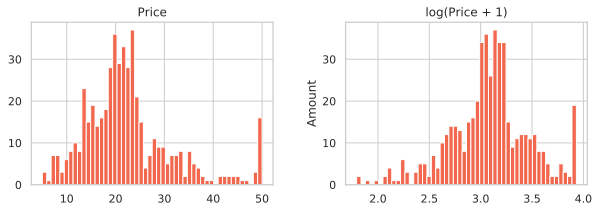

In [4]:
prices = pd.DataFrame({"Price":df["MEDV"], "log(Price + 1)":np.log1p(df["MEDV"])})

prices.hist(color="#F1684E", bins=50, figsize=(10,3))
plt.ylabel("Amount");

We can see that our distribution has been less spaced and a little closer to a normal distribution, but Python has a statistical function that helps us evaluate whether this will be necessary or not, through the Box-Cox test that will have clues with the degree of skewness.

In [5]:
from scipy.stats import skew

for col in df.keys():
    sk = skew(df[col])
    if sk > 0.75:
        print(col, sk)

CRIM 5.207652387859715
ZN 2.219063057148425
CHAS 3.395799292642519
DIS 1.0087787565152246
RAD 1.0018334924536951
LSTAT 0.9037707431346133
MEDV 1.104810822864635


#### Um Pouco de Feature Engeneering
O teste de Box-Cox[^5] nos diz que um skew acima de 0.75 pode ser linearizado pela função log(x+1), fazendo a distribuição ficar mais normalizada, abaixo disso posso manter o valor como estava sem necessidades de modificação, vamos olhar o antes e depois de aplicar essa função a nossas distribuições. (Suprimi algumas variáveis para não poluir demais o gráfico).

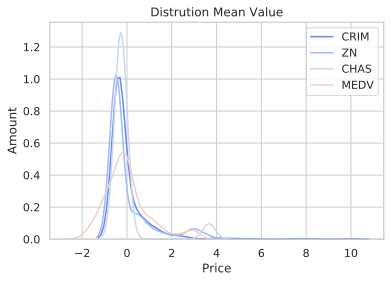

In [6]:
dfnorm = (df - df.mean()) / (df.std())
for x in ["CRIM", "ZN", "CHAS","MEDV"]:
    sns.kdeplot(dfnorm[x])
plt.title("Distrution Mean Value")
plt.xlabel("Price")
plt.ylabel("Amount");

In [7]:
for col in df.keys():
    sk = skew(df[col])
    if sk > 0.75:
        df[col] = np.log1p(df[col])

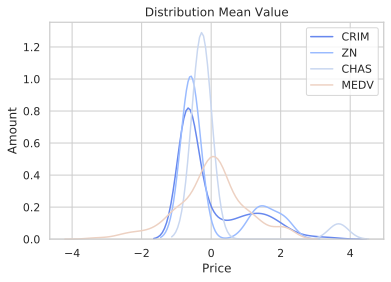

In [8]:
dfnorm = (df - df.mean()) / (df.std())
for x in ["CRIM", "ZN", "CHAS","MEDV"]:
    sns.kdeplot(dfnorm[x])
plt.title("Distribution Mean Value")
plt.xlabel("Price")
plt.ylabel("Amount");

Vemos que as distribuições ficaram muito mais centradas e tendendo a distribuição gaussiana[^2], o que será excelente para o ajuste dos nossos estimadores[^3]. Sendo a função logarítmica e a função f.x+1 bijetoras, poderemos retornar ao nosso valor original assim que acabarmos o ajuste do modelo.


#### Simplificando nossos dados

Nossos dados ainda podem estar muito complexos, a escala em que se encontram e talvez um excesso de informação necessária podem impossibilitar que nosso modelo atinja a perfeição. Aqui iremos aplicar duas técnicas, a primeira e escalonamento de variáveis pelo máximo-mínimo, transformação que também é reversível é poderá ser desfeita ao preço final, bastando eu guardar as variáveis da minha transformação.

In [9]:
df.std()

CRIM         1.022731
ZN           1.620831
INDUS        6.860353
CHAS         0.176055
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          0.413390
RAD          0.751839
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        0.539033
MEDV         0.386966
dtype: float64

It is visible that some variables are extremely dispersed, we can change this with the following formula:

$$ z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)} $$

Thus our variables will be between zero and one, making the prediction simpler.

In [10]:
dfmin, dfmax = df.min(), df.max()
df = (df - df.min())/(df.max()-df.min())
df.std()

CRIM       0.227615
ZN         0.351200
INDUS      0.251479
CHAS       0.253994
NOX        0.238431
RM         0.134627
AGE        0.289896
DIS        0.227300
RAD        0.297672
TAX        0.321636
PTRATIO    0.230313
B          0.230205
LSTAT      0.202759
MEDV       0.180819
dtype: float64

Great!!

#### All ready

Finished our data tuning after so much work we are now going to adjust our models, get used to it, handling the data is what will consume you most time in a machine learning process. But finally let's take a final look at how they got distributed. I will use the internal function of Pandas, boxplot, if you have any doubt what this chart represents, see [here](https://en.wikipedia.org/wiki/Box_plot).

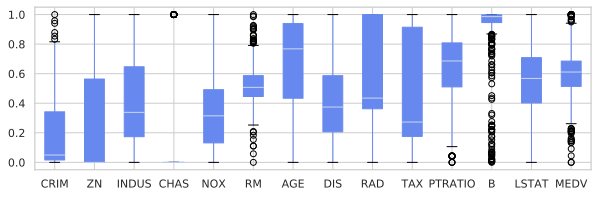

In [11]:
df.plot.box(figsize=(10,3), patch_artist=True);

As already discussed in other posts, we should separate the data into a training and testing set, to train our model and to know how well our model will predict for unknown cases. Read [this article](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) for a better understanding.

Here we use Scikit-Learn's built-in function to separate data, for additional information on all of the function variables below I suggest consulting the [official documentation](http://scikit-learn.org/stable/documentation.html). As the first argument I pass my X, attributes, and the second argument my y, the value I want to predict, finally I pass an integer to make my results reproducible by making the random processes of functions nonrandom.

In [12]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest =\
    train_test_split(df.drop('MEDV',1).values, df['MEDV'].values, random_state=201)

Now we will import our two models, the first one being XGBoost, an algorithm that has been proving extremely efficient in competitions and the famous Ridge regression algorithm. We will evaluate our models by [square mean error](https://en.wikipedia.org/wiki/Mean_squared_error).

In [13]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Here I perform a slight improvement on the hyperparameters with GridSearchCV to look for the combination of the hyperparameters that will give me a better prediction, then I adjust my model to the data and having it train, I predict data it doesn't know, then evaluate the model performance as said.

In [14]:
params = {'alpha': np.linspace(0.1,1,200),
          'random_state':[2020]}

model1 = GridSearchCV(estimator = Ridge(), param_grid = params, cv=5)
model1.fit(xtrain,ytrain)
linpred = model1.predict(xtest)

err1 = mean_squared_error(linpred, ytest)
print(err1)

0.00745856883004946


In [15]:
params = {'reg_alpha': np.linspace(0,1,10),
          'gamma': np.linspace(0,1,1),
          'reg_lambda': np.linspace(0,1,1)}

model2 = GridSearchCV(estimator = LGBMRegressor(), param_grid = params, cv=5)
model2.fit(xtrain, ytrain)
lgbmpred = model2.predict(xtest)

err2 = mean_squared_error(lgbmpred, ytest)
print(err2)

0.005040440132637956


Very good results, but can we make them even better?! Let's look at whether our predictions have a low correlation.

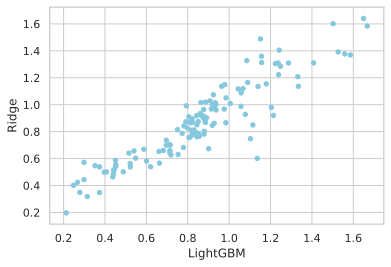

In [16]:
predictions = pd.DataFrame({"LightGBM":np.expm1(lgbmpred), "Ridge":np.expm1(linpred)})
predictions.plot(x = "LightGBM", y = "Ridge", kind = "scatter", color="#85C8DD");

As already explained, a low correlation tends to significantly improve our prediction, visually we have something significant, let's look at that now in numbers.

In [17]:
from scipy import stats
_, _, r_value, _, std_err = stats.linregress(np.expm1(lgbmpred),np.expm1(linpred))
print(r_value, std_err)

0.9193021766109413 0.03313351573076193


Because our r-value is not too high (<.95), we can benefit from the combination of estimates. We get to the initial motivation part of combining models to increase predictive performance. I will test 3 combinations of predictions, weighted mean, simple mean, and harmonic mean.

In [18]:
err3 = mean_squared_error(lgbmpred * 0.8 + linpred * 0.2, ytest) # weighted mean
err4 = mean_squared_error((lgbmpred + linpred)/2, ytest) # mean
err5 = mean_squared_error(stats.hmean([lgbmpred, linpred]), ytest) # harmonic mean
print(err3, err4, err5)

0.004830881999425605 0.005166404680258313 0.004927370731820139


Excelente, ouve uma melhora significativa, mas o quão significativa?

In [19]:
1-err3/err2

0.041575363995579706

That's right, a 4% improvement from our best estimator, quite significant for something so simple, and such improvements over high performance algorithms are of utmost importance in the data science world, perhaps even help us jump thousands of positions towards top in a competition worth $ 1.2 million [^4].

### Concluding

The main purpose of this publication was to demonstrate that a simple combination of two models can significantly impact their prediction, but during this process I did some data treatment that will impress you on the impact of reducing our error, try evaluating the models without performing some of the treatments I gave to the data ... In future publications, more will be explained about each technique seen here.

#### References
[^1]: Polikar, R. (2006). "Ensemble based systems in decision making". IEEE Circuits and Systems Magazine. 6 (3): 21–45. doi:10.1109/MCAS.2006.1688199

[^2]: https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va

[^3]: https://stats.stackexchange.com/questions/18844/when-and-why-should-you-take-the-log-of-a-distribution-of-numbers

[^4]: https://www.kaggle.com/c/zillow-prize-1

[^5]: http://www.itl.nist.gov/div898/handbook/eda/section3/eda336.htm

[Inverse Variance](https://en.wikipedia.org/wiki/Inverse-variance_weighting)

[Bootstrap_aggregating Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

[Regularized Linear Models Kernel](https://www.kaggle.com/apapiu/regularized-linear-models)